# DEAP Dataset + Spectrogram + CNN2D (4 layers)

In this part, we shall try inputting the spectrogram into 4 layers of CNN2D.

*Note that we will be only predicting the valence.  Feel free to work on the arousal yourself.*

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os, pickle

# setting seed so that splitting process and training process can be reproduce
torch.manual_seed(1)

import numpy as np

#refactoring components
#maybe you want to take a look at these components, because we will be using them in the future series
from components.dataset import Dataset, SpecDataset
from components.helper import getLoaders, count_parameters, plot_performance
from components.train import train, evaluate, initialize_weights

Set cuda accordingly.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Configured device: ", device)

Configured device:  cuda


## 1. Loading the SpecDataset

Here we gonna just refactor the code and put into the <code>components/dataset.py</code> folder

In [3]:
path = "data"  #create a folder "data", and inside put s01.dat,....,s32.dat inside from the preprocessed folder from the DEAP dataset

sample_rate = 128
window_size = int(sample_rate)  #1s
step_size = sample_rate * 0.5 #0.5s

In [4]:
#def __init__(self, path, stim, sample_rate, window_size, step_size, segments):
#6 here means breaking 60s video into 10 segments.  We have selected this from trial-and-error.  Too high or low leads to worse accuracy - that's what we found.
dataset = SpecDataset(path, "Valence", sample_rate, window_size, step_size, 6)

data  = dataset[:]['data']
label = dataset[:]['label']

print("Data shape: " , data.shape)  # batches, channels, height, width
print("Label shape: ", label.shape)  #two classes of valence

Data shape:  torch.Size([7680, 32, 20, 65])
Label shape:  torch.Size([7680, 1])


## 2. Defining the Model

Here we will try 4 layers.  Let's get the shapes so we can define our CNN dynamically.

Note that I only put maxpool at layer2 and 4.  This is because if we put too many maxpool, the size of the images will be reduced too drastically, losing information.  This is especially true since we already segmented our data in the beginning.

Thus I have keep it consistent with previous tutorial, i.e., 2 maxpooling.

### Getting shape so we can make sure our convolution always work dynamically

In [5]:
conv2d1 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

conv2d2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
maxpool2 = nn.MaxPool2d(kernel_size=2)

conv2d3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

conv2d4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
maxpool4 = nn.MaxPool2d(kernel_size=2)

In [6]:
out = conv2d1(data)
out.shape

torch.Size([7680, 64, 20, 65])

In [7]:
out = conv2d2(out)
out.shape

torch.Size([7680, 128, 20, 65])

In [8]:
out = maxpool2(out)
out.shape

torch.Size([7680, 128, 10, 32])

In [9]:
out = conv2d3(out)
out.shape

torch.Size([7680, 256, 10, 32])

In [10]:
out = conv2d4(out)
out.shape

torch.Size([7680, 512, 10, 32])

In [11]:
out = maxpool4(out)
final_shape = out.shape
print(out.shape)

torch.Size([7680, 512, 5, 16])


### Model Definition

In [12]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, input_dim=32, output_dim=1):
        super(ConvNet, self).__init__()
        
        #using sequential helps bind multiple operations together
        self.layer1 = nn.Sequential(
            #in_channel = 32, #out_channel = 64
            nn.Conv2d(input_dim, input_dim*2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(input_dim*2),
            nn.ReLU())
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(input_dim*2, input_dim*4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(input_dim*4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(input_dim*4, input_dim*8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(input_dim*8),
            nn.ReLU())
            
        self.layer4 = nn.Sequential(
            nn.Conv2d(input_dim*8, input_dim*16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(input_dim*16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        
        self.fc = nn.Linear(final_shape[1]*final_shape[2]*final_shape[3], output_dim)

        self.drop_out = nn.Dropout(p=0.2)  #zeroed 0.2% data
        #after fc will be of shape [batch, 1]
        
    def forward(self, x):
        #x shape: [batch, in_channel, img_width, img_height]
        out = self.layer1(x)
        out = self.drop_out(out)
        out = self.layer2(out)
        out = self.drop_out(out)
        out = self.layer3(out)
        out = self.drop_out(out)
        out = self.layer4(out)
        out = self.drop_out(out)
        
        out = out.reshape(out.size(0), -1)   #can also use .view()
        #we squeeze so that it can be inputted into the fc layer
        
        out = self.fc(out)
        #after fc layer: shape: [batch, 1]
        return out

**Model init**: Let's init the class instance and create a workabout model.

In [13]:
input_dim     = 32 #we got 32 EEG channels
output_dim    = 1  #we got 2 classes for our labels

#define the model
model = ConvNet(input_dim, output_dim)

#send to cuda so we can use the GPU
model = model.to(device)  

#apply weights
model.apply(initialize_weights)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil

**Param count**: Let's also check the number of parameters used

In [14]:
print(f'The model {type(model).__name__} has {count_parameters(model):,} trainable parameters')# Train the model

The model ConvNet has 1,610,561 trainable parameters


**Unit test**: Let's define a simple unit test, inputing some mock EEG data and see whether we got the desired output as 4 classes.

In [15]:
mock_batch_size = 2   
mock_input_dim  = 32   
mock_height     = data.shape[2]  #need to use real shape to make sure CNN layers work
mock_width      = data.shape[3]

#note that our model first layer is conv1d which expects (batch, channel, height, width)
mock_eegdata = torch.rand(mock_batch_size, mock_input_dim, mock_height, mock_width).to(device)

#let's try run the model by simply inserting the mockdata into the model; very similar to .fit
predictions = model(mock_eegdata)

#let's try to see the predictions whether it really outputs 2 unique classes - 0 and 1
print("Prediction shape: ", predictions.shape)
print("Predictions: ", predictions)

#simple unit test
assert predictions.shape[0] == mock_batch_size
assert predictions.shape[1] == output_dim

Prediction shape:  torch.Size([2, 1])
Predictions:  tensor([[-0.5197],
        [ 2.1632]], device='cuda:0', grad_fn=<AddmmBackward>)


## 4. Training

### I. Batch Iterators

To make it easier to manage, I have put this into our <code>components/helper.py</code>.

In [16]:
train_loader, val_loader, test_loader = getLoaders(dataset=dataset, batch_size=16)

Full Dataset size:  7680
Train Dataset size: 5376
Valid Dataset size: 1536
Test Dataset size:  768



### II. Optimizers

Optimizer simply refers to the one that gonna take care of the backpropagation process.  The commonly used optimizer is SGD and Adam, both are quite interchangeable.  Here we gonna use Adam.  In order to backpropagate, we gonna define a loss function using cross entropy loss, which is a common loss function for multi-class purposes.

In [17]:
import torch.optim as optim

num_epochs = 50

lr = 0.0001

#can also try SGD which should not make too much of a difference
optimizer = optim.Adam(model.parameters(), lr=lr) 

#combine sigmoid with binary entropy; binary entropy is used for binary classification
criterion = nn.BCEWithLogitsLoss() 

### III. Let's train!

In [18]:
model_saved_name = "models/DEAP_Specgram_CNN2D_4layers.pt"

#trainer(num_epochs, model, train_loader, val_loader, optimizer, criterion, model_name, device, seq_len_first=False)
train_losses, valid_losses, train_accs, valid_accs = train(num_epochs, model, train_loader, val_loader, optimizer, criterion, model_saved_name, device)

Epoch: 01 | Epoch Time: 0m 4s
	 Train Loss: 0.899 | Train Acc: 55.62%
	 Val. Loss: 0.670  |  Val. Acc: 60.03%
Epoch: 02 | Epoch Time: 0m 3s
	 Train Loss: 0.834 | Train Acc: 58.28%
	 Val. Loss: 0.661  |  Val. Acc: 61.52%
Epoch: 03 | Epoch Time: 0m 3s
	 Train Loss: 0.728 | Train Acc: 62.56%
	 Val. Loss: 0.596  |  Val. Acc: 67.84%
Epoch: 04 | Epoch Time: 0m 3s
	 Train Loss: 0.713 | Train Acc: 64.60%
	 Val. Loss: 0.577  |  Val. Acc: 69.60%
Epoch: 05 | Epoch Time: 0m 3s
	 Train Loss: 0.716 | Train Acc: 65.22%
	 Val. Loss: 0.820  |  Val. Acc: 56.38%
Epoch: 06 | Epoch Time: 0m 3s
	 Train Loss: 0.622 | Train Acc: 69.70%
	 Val. Loss: 0.529  |  Val. Acc: 72.92%
Epoch: 07 | Epoch Time: 0m 3s
	 Train Loss: 0.621 | Train Acc: 69.49%
	 Val. Loss: 0.538  |  Val. Acc: 72.59%
Epoch: 08 | Epoch Time: 0m 3s
	 Train Loss: 0.569 | Train Acc: 72.06%
	 Val. Loss: 0.706  |  Val. Acc: 64.39%
Epoch: 09 | Epoch Time: 0m 3s
	 Train Loss: 0.536 | Train Acc: 74.11%
	 Val. Loss: 0.479  |  Val. Acc: 76.56%
Epoch: 10 

Let's plot the losses and acc for easier inspection

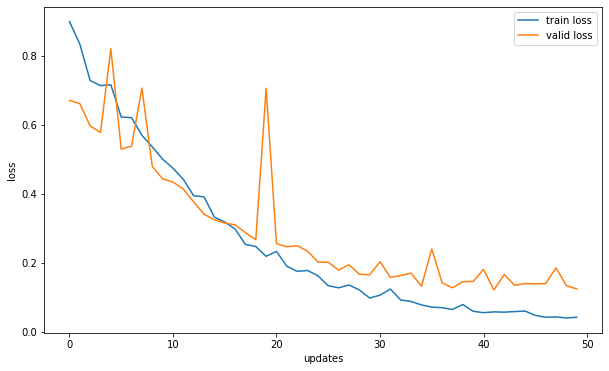

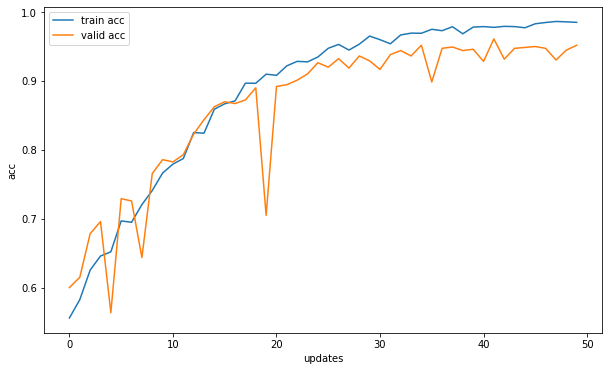

In [19]:
plot_performance(train_losses, valid_losses, "loss")
plot_performance(train_accs, valid_accs, "acc")

## 5. Evaluation on test set

In [20]:
model.load_state_dict(torch.load(model_saved_name))
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.094 | Test Acc: 96.61%


## Final Verdict



Wow, this accuracy is really impressive...a whooping 96%.  It is clear that spectrogram offers both fast and very accurate results.